# Abstraction-based analysis of neural networks

## Reading NNET files and building neural networks in Julia

In [1]:
using NeuralVerification, LazySets
import NeuralVerification: Network, Layer, ReLU, Id, compute_output, ActivationFunction, get_bounds
using Plots
using LinearAlgebra

We can read a network from a [.nnet](https://github.com/sisl/NNet) file using the [read_nnet](https://sisl.github.io/NeuralVerification.jl/latest/functions/#NeuralVerification.read_nnet) utility function from the Julia Neural Verification library.
We take as example the network from file [small_nnet_id.nnet](https://github.com/sisl/NeuralVerification-CARS-Workshop/blob/master/models/small_nnet_id.nnet), which has two hidden layers with two nodes each. Let us first read the file as text to see what it looks like.

In [2]:
println(read("models/small_nnet_id.nnet", String))

3
1, 2, 2, 1
0
0
0
0
0
1
1
1.5
1.5
2, 2
2, 2
2.5
2.5
-3, -3
3.5



Above we see the exact contents of the .nnet file at text. The first line is how many layers are in the network (2 hidden plus the input makes 3). The next line tells the input size of each layer, as well as the output size of the network (1). The following rows with zeros do nothing usually and are skipped in parsing. After that are listed the weights and biases of each layer.
We can parse this text file into a [Network]((https://sisl.github.io/NeuralVerification.jl/latest/problem/#Network)) object using [read_nnet](https://sisl.github.io/NeuralVerification.jl/latest/functions/#NeuralVerification.read_nnet). 

In [3]:
net = read_nnet("models/small_nnet_id.nnet")

Network(Layer[Layer{ReLU, Float64}([1.0; 1.0;;], [1.5, 1.5], ReLU()), Layer{ReLU, Float64}([2.0 2.0; 2.0 2.0], [2.5, 2.5], ReLU()), Layer{Id, Float64}([-3.0 -3.0], [3.5], Id())])

A [Network](https://sisl.github.io/NeuralVerification.jl/latest/problem/#Network) is defined as a vector of Layers. For each Layer, we can print the Weights, Bias and [Activation functions](https://sisl.github.io/NeuralVerification.jl/latest/problem/#Activation-Functions): 

In [4]:
net.layers

3-element Vector{Layer}:
 Layer{ReLU, Float64}([1.0; 1.0;;], [1.5, 1.5], ReLU())
 Layer{ReLU, Float64}([2.0 2.0; 2.0 2.0], [2.5, 2.5], ReLU())
 Layer{Id, Float64}([-3.0 -3.0], [3.5], Id())

In [5]:
net.layers[1].weights

2×1 Matrix{Float64}:
 1.0
 1.0

In [6]:
net.layers[1].bias

2-element Vector{Float64}:
 1.5
 1.5

In [7]:
net.layers[1].activation

ReLU()

It is also possible to create a Network by putting together a series of Layers manually: 

In [8]:
W = [1.0 0.5;
     0.5 1.0]

b = [0, -0.5]

L1 = Layer(W, b, ReLU())

Layer{ReLU, Float64}([1.0 0.5; 0.5 1.0], [0.0, -0.5], ReLU())

We can apply the layer to an input, decomposing the affine map then the action of the activation function:

In [9]:
x = [2,-1]
y = NeuralVerification.affine_map(L1,x)

2-element Vector{Float64}:
  1.5
 -0.5

In [10]:
z = L1.activation(y)

2-element Vector{Float64}:
 1.5
 0.0

A Network consists of a vector of such Layers. Here for example we construct a network using 2 identical layers

In [11]:
layers = [L1, L1]
net = Network(layers)

Network(Layer[Layer{ReLU, Float64}([1.0 0.5; 0.5 1.0], [0.0, -0.5], ReLU()), Layer{ReLU, Float64}([1.0 0.5; 0.5 1.0], [0.0, -0.5], ReLU())])

## Building your own network and performing interval-based approximate reachability 

Now build this test network: ![test network](test_network1.png)

In [12]:
W = [1.0 1.0; 1.0 -1.0]
b = [0.0, 0.0]
L1 = Layer(W, b, ReLU())
L2 = Layer(W, b, Id())
net = Network([L1, L2])

Network(Layer[Layer{ReLU, Float64}([1.0 1.0; 1.0 -1.0], [0.0, 0.0], ReLU()), Layer{Id, Float64}([1.0 1.0; 1.0 -1.0], [0.0, 0.0], Id())])

We can now compute the output of the network, given an input vector. Let us take for instance the center of the input boxes of the network.

In [13]:
compute_output(net, [1.0, 0.0])

2-element Vector{Float64}:
 2.0
 0.0

## Using built-in abstraction-based solvers (AI2)

Let us build an Hyperrectangle corresponding to the input boxes of the above network, and the [Reachability Problem](https://sisl.github.io/NeuralVerification.jl/latest/problem/) starting from this input hyperrectangle. Note that the output is useful only if we want to verify whether the output satisfies some property, here we are not interested in this functionality and select X as output. 

In [14]:
X = Hyperrectangle(low = [0.7, -0.3], high = [1.3, 0.3])
problem = Problem(net, X, X)

Problem{Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}, Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}}(Network(Layer[Layer{ReLU, Float64}([1.0 1.0; 1.0 -1.0], [0.0, 0.0], ReLU()), Layer{Id, Float64}([1.0 1.0; 1.0 -1.0], [0.0, 0.0], Id())]), Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([1.0, 0.0], [0.30000000000000004, 0.3]), Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([1.0, 0.0], [0.30000000000000004, 0.3]))

Let us now [solve](https://sisl.github.io/NeuralVerification.jl/latest/solvers/) the problem using 
the box and zonotopes abstractions from the abstraction-based [AI2 reachability solver](https://sisl.github.io/NeuralVerification.jl/latest/solvers/#Ai2).

In [15]:
result_box = solve(Box(),problem)
result_zono = solve(Ai2z(),problem)

ReachabilityResult(:violated, Zonotope{Float64, Vector{Float64}, Matrix{Float64}}[Zonotope{Float64, Vector{Float64}, Matrix{Float64}}([2.0, 0.0], [0.6000000000000001 0.0; 0.0 0.6])])

Let us now plot the reachable sets with the two abstractions. 
We can note that the zonotope abstraction indeed gives the expected result, 
while the box abstraction result is wider but not exactly what we expect from a box abstraction. 

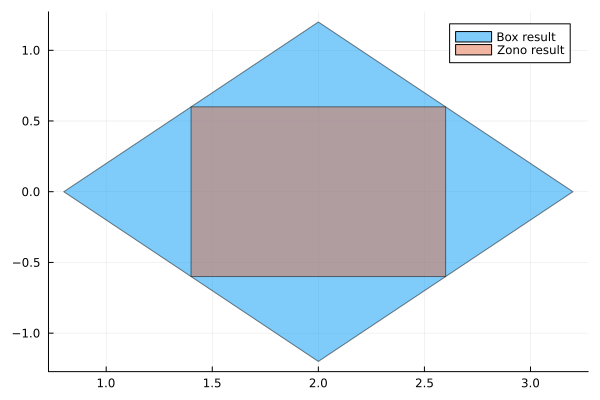

In [16]:
#result_poly = solve(Ai2h(),problem)
plot(result_box.reachable, label = "Box result", legend = true)
plot!(result_zono.reachable, label = "Zono result")


Actually the get_bounds function performs the actual Box/Hyperrectangles abstraction that we expect (and is thus the reference for the interval abstraction that you will later implement:

In [17]:
result_bounds = get_bounds(net,X)

3-element Vector{Hyperrectangle}:
 Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([1.0, 0.0], [0.30000000000000004, 0.3])
 Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([1.0, 1.0], [0.6000000000000001, 0.6000000000000001])
 Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([2.0, 0.0], [1.2000000000000002, 1.2000000000000002])

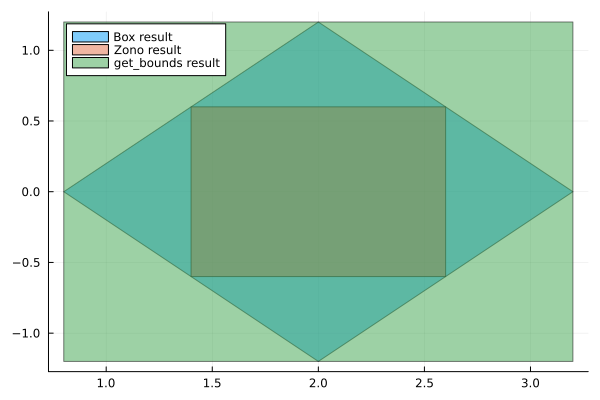

In [18]:
plot!(result_bounds[3], label = "get_bounds result")

## Building our own interval-based approximate reachability analysis

Now let us build an interval abstraction, using [Hyperrectangles](https://juliareach.github.io/LazySets.jl/dev/lib/sets/Hyperrectangle/), of such a small neural network, by completing the below functions. Here, you are expected to encode by yourself the action of an affine map (i.e. not use the existing function) and the activation functions.

Some tips:
- you can build a Hyperrectangle both from lower and upper bound (noted H = Hyperrectangle(low=Imin, high=Imax)) or from center and radius (noted H = Hyperrectangle(c, r)). The latter may be more convient to compute the affine transform of an Hyperrectangle. 
- you can use the low() and high() functions on a Hyperrectangle to get its lower and upper bounds
- you can use the '.' notation to apply a saclar function elementwise to an array (for example x = [1, 2]; f(x) = x*x; y = f.(x))
- you can simply write 'A * x + b' for an affine transform of a vector of floats.


In [19]:
function interval_approximate_act_map(act::ActivationFunction, input::Hyperrectangle)
    Imax = act.(high(input))
    Imin = act.(low(input))
    return Hyperrectangle(low=Imin, high=Imax)
end

interval_approximate_act_map (generic function with 1 method)

In [20]:
function interval_approximate_affine_map(layer::Layer, input::Hyperrectangle)
    c = layer.weights * input.center + layer.bias; 
    r = abs.(layer.weights) * input.radius
    return Hyperrectangle(c, r)
end

interval_approximate_affine_map (generic function with 1 method)

In [21]:
function interval_approximate_nnet(nnet::Network, input::Hyperrectangle)
    bounds = Vector{Hyperrectangle}(undef, length(nnet.layers) + 1)
    bounds[1] = input
    for i in 1:length(nnet.layers)
        temp = interval_approximate_affine_map(nnet.layers[i],bounds[i])
        bounds[i+1] = interval_approximate_act_map(nnet.layers[i].activation,temp)
    end

    return bounds
end

interval_approximate_nnet (generic function with 1 method)

Now test these functions and make sure the results match the example of the lecture. 

In [22]:
interval_result = interval_approximate_nnet(net, X)

3-element Vector{Hyperrectangle}:
 Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([1.0, 0.0], [0.30000000000000004, 0.3])
 Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([1.0, 1.0], [0.6000000000000001, 0.6000000000000001])
 Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([2.0, 0.0], [1.2000000000000002, 1.2000000000000002])

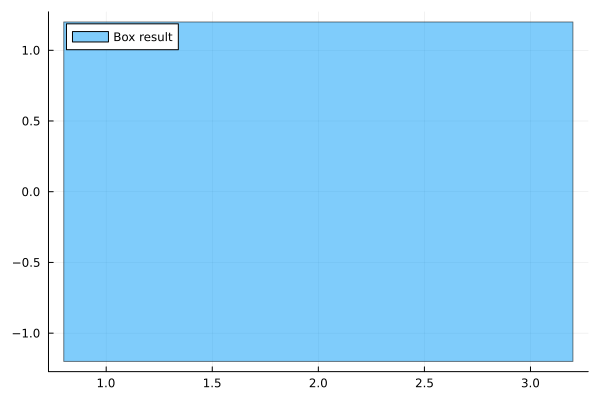

In [23]:
plot(interval_result[length(net.layers)+1], label = "Box result", legend = true)

## Now encode and test a simple zonotopic abstraction in a similar way
You are welcome here to use [Zonotopes](https://juliareach.github.io/LazySets.jl/dev/lib/sets/Zonotope/) from the [LazySets Library](https://juliareach.github.io/LazySets.jl/dev/) and existing operations such as the affine_map function. You will still need to encode the action of the activation functions (focus on Identity and ReLU). For ReLU, please implement the transformer which is minimeal in term of area in the input-output plane (see lecture).

Note that writing 'A * x + b' where x is a zonotope, A a weights matrix and b a vector instead of using affine_map,  creates an AffineMap object using the [Lazy paradigm](https://juliareach.github.io/LazySets.jl/dev/man/tour/#The-Lazy-paradigm). This new object wraps the computation of the affine map until it is actually needed. In order to get a set which contains the result of operations on Lazy sets such as Zonotopes, you would need to call the [concretize](https://juliareach.github.io/LazySets.jl/dev/lib/interfaces/#LazySets.concretize-Tuple{LazySet}) function on this object.) 

In [24]:
function zono_approximate_act_map(act::ActivationFunction, input::Zonotope)
    if (act == Id())
        return input
    elseif (act == ReLU())
        if (all(>=(0),low(input))) # if all components of the zonotope are greater than zero
            return input
        else
            lambda = high(input)./(high(input)-low(input))
            center_Z = lambda .* LazySets.center(input) - lambda .* low(input)/2.0
            gen_Z = lambda .* genmat(input)
            Z = Zonotope(center_Z,gen_Z)
            dim_X = length(lambda)
            new_gen = Zonotope(zeros(dim_X), diagm(lambda.*low(input)/2.0))
            return minkowski_sum(Z,new_gen)
        end
    else 
        print("warning, ",act," not yet implemented")
        return input
    end
end

zono_approximate_act_map (generic function with 1 method)

In [25]:
function zono_approximate_affine_map(layer::Layer, input::Zonotope)
    return affine_map(layer.weights, input,layer.bias)
    #return concretize(layer.weights * input +layer.bias)
end

zono_approximate_affine_map (generic function with 1 method)

In [26]:
function zono_approximate_nnet(nnet::Network, input::Hyperrectangle)
    bounds = Vector{Zonotope}(undef, length(nnet.layers) + 1)
    bounds[1] = input
    for i in 1:length(nnet.layers)
        temp = zono_approximate_affine_map(nnet.layers[i],bounds[i])
        print("temp affine_map = ",temp)
        bounds[i+1] = zono_approximate_act_map(nnet.layers[i].activation,temp)
    end

    return bounds
end

zono_approximate_nnet (generic function with 1 method)

In [27]:
zono_result = zono_approximate_nnet(net, X)

temp affine_map = Zonotope{Float64, Vector{Float64}, Matrix{Float64}}([1.0, 1.0], [0.30000000000000004 0.3; 0.30000000000000004 -0.3])temp affine_map = Zonotope{Float64, Vector{Float64}, Matrix{Float64}}([2.0, 0.0], [0.6000000000000001 0.0; 0.0 0.6])

3-element Vector{Zonotope}:
 Zonotope{Float64, Vector{Float64}, Matrix{Float64}}([1.0, 0.0], [0.30000000000000004 0.0; 0.0 0.3])
 Zonotope{Float64, Vector{Float64}, Matrix{Float64}}([1.0, 1.0], [0.30000000000000004 0.3; 0.30000000000000004 -0.3])
 Zonotope{Float64, Vector{Float64}, Matrix{Float64}}([2.0, 0.0], [0.6000000000000001 0.0; 0.0 0.6])

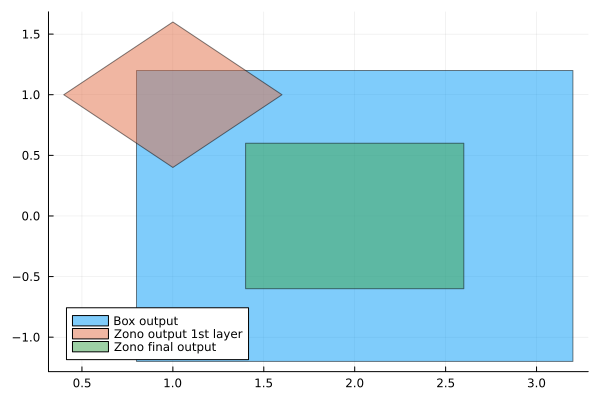

In [28]:
plot(interval_result[length(net.layers)+1], label = "Box output", legend = true)
plot!(zono_result[length(net.layers)], label = "Zono output 1st layer")
plot!(zono_result[length(net.layers)+1], label = "Zono final output")

Let us now test your ReLU abstraction on another example. Correct it if necessary...

In [29]:
# one-dimensional zonotope 
X2 = Zonotope([-0.5], [[1.5]])

Zonotope{Float64, Vector{Float64}, Matrix{Float64}}([-0.5], [1.5;;])

In [30]:
res_ReLU = zono_approximate_act_map(ReLU(),X2)

Zonotope{Float64, Vector{Float64}, Matrix{Float64}}([0.16666666666666666], [0.5 -0.3333333333333333])

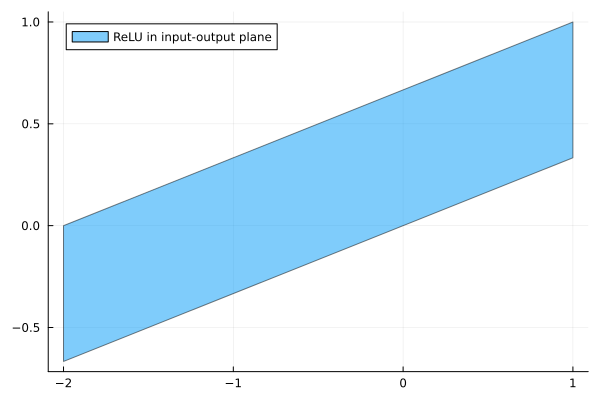

In [31]:
# building the 2-dimensional zonotope (X2,res_ReLU) in order to visualize it
input_output_zono = Zonotope(vcat(-0.5,LazySets.center(res_ReLU)), vcat([1.5 0.0],genmat(res_ReLU)))
plot(input_output_zono,label = "ReLU in input-output plane", legend = true)

Let us now go 2-dimensional to make sure your functions still work fine: they should apply the ReLU componentwise on the dimensions of the Zonotope input to produce a Zonotope output. 

In [32]:
X3 = Zonotope([-0.5, -0.5], [[1.5, 1.5]])

Zonotope{Float64, Vector{Float64}, Matrix{Float64}}([-0.5, -0.5], [1.5; 1.5;;])

What does the X3 zonotope represent ? 

Let us now apply the ReLU function to X3. 

In [33]:
res_ReLU3 = zono_approximate_act_map(ReLU(),X3)

Zonotope{Float64, Vector{Float64}, Matrix{Float64}}([0.16666666666666666, 0.16666666666666666], [0.5 -0.3333333333333333 0.0; 0.5 0.0 -0.3333333333333333])

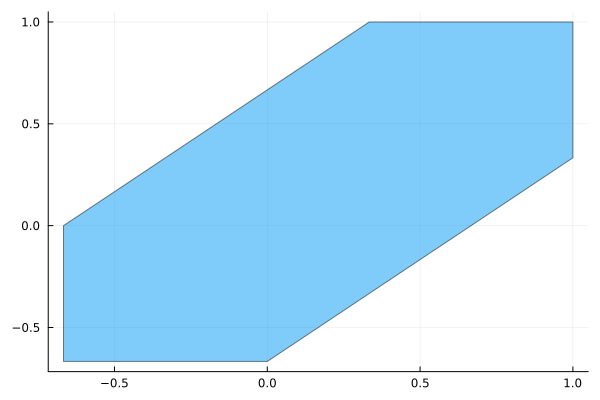

In [34]:
plot(res_ReLU3)

You probably noted that there has been some over-approximation here, due to applying ReLU independently on each dimension and creating a new noise symbol for each dimension. This is the problem addressed by the article on the "k-ReLU" technique mentioned in Lecture 2. 

### Testing on another network

Finally, let us test your analysis on another network (where your ReLU abstraction is needed) and compare it to the result of AI2

In [35]:
W1 = [1 -2.0; -1.0 0.5; 1.0 1.5]
b1 = [0.5; 1.0; -0.5]
W2 = [-1.0 -1.0 1.0; 2.0 1.0 -0.5]
b2 = [-0.2; -1.0]
L1 = Layer(W1, b1, ReLU())
L2 = Layer(W2, b2, Id())
net = Network([L1, L2])

Network(Layer[Layer{ReLU, Float64}([1.0 -2.0; -1.0 0.5; 1.0 1.5], [0.5, 1.0, -0.5], ReLU()), Layer{Id, Float64}([-1.0 -1.0 1.0; 2.0 1.0 -0.5], [-0.2, -1.0], Id())])

temp affine_map = Zonotope{Float64, Vector{Float64}, Matrix{Float64}}([0.5, 1.0, -0.5], [2.0 -2.0; -2.0 0.5; 2.0 1.5])temp affine_map = Zonotope{Float64, Vector{Float64}, Matrix{Float64}}([-2.047767857142857, 2.4348214285714285], [1.1321428571428571 1.4178571428571427 0.984375 0.5249999999999999 -0.8571428571428571; 0.42142857142857154 -2.2214285714285715 -1.96875 -0.5249999999999999 0.42857142857142855])

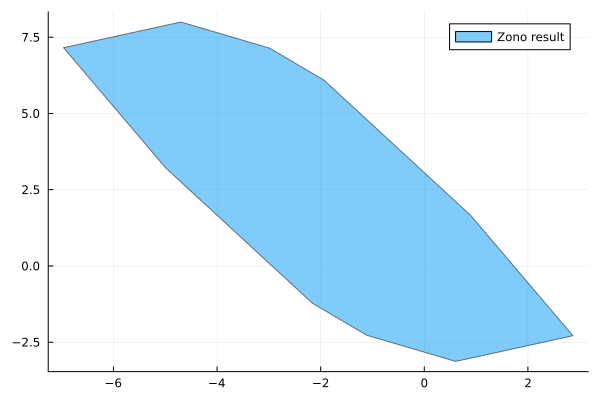

In [36]:
X = Hyperrectangle(low = [-2., -1.], high = [2., 1.])
zono_result = zono_approximate_nnet(net, X)
Plots.plot(zono_result[3], label = "Zono result")

Your result should be compared to the result of Ai2z below:

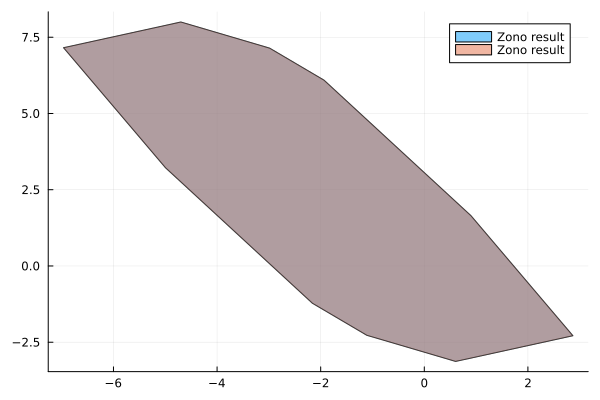

In [37]:
problem = Problem(net, X, X)
result_zono = solve(Ai2z(),problem)
plot!(result_zono.reachable, label = "Zono result")

## Going further (optional)
Implement and experiment a zonotopic abstraction for other activation functions (tanh, sigmoid)